# CSII 2025 Exercise 9: Q parametrization & Internal Model Control & $H_{\infty}$ Control
© 2025 ETH Zurich, Aya Abrini, Livia Fischer, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

# Setup

In [101]:
# Install the required python library with pip
%pip install --upgrade cs2solutions
%pip install control==0.10.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 0.9.3, 0.9.3.post1
ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python >=3.10; 0.10.1 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement control==0.10.0 (from versions: 0.6.0, 0.6.1, 0.6.2, 0.6.5, 0.6.6, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.8.3, 0.8.4, 0.9.0, 0.9.1, 0.9.2, 0.9.3.post2, 0.9.4)
ERROR: No matching distribution found for control==0.10.0


In [102]:
# Import dependencies
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from scipy import signal as signal
import scipy.linalg as la
from cs2solutions import duckiebot, Qparam, H_inf

# Exercise 1: Q-Parametrization for CS2-Bot Controller Design
Recall the CS2-Bot first used in Problem Set 03, where the advantages of state feedback were demonstrated. In Problem Set 04, we added a state estimator and introduced optimal control for it in Problem Set 05. In this problem set, the task is to parametrize all stabilizing controllers using a Q-parametrization.

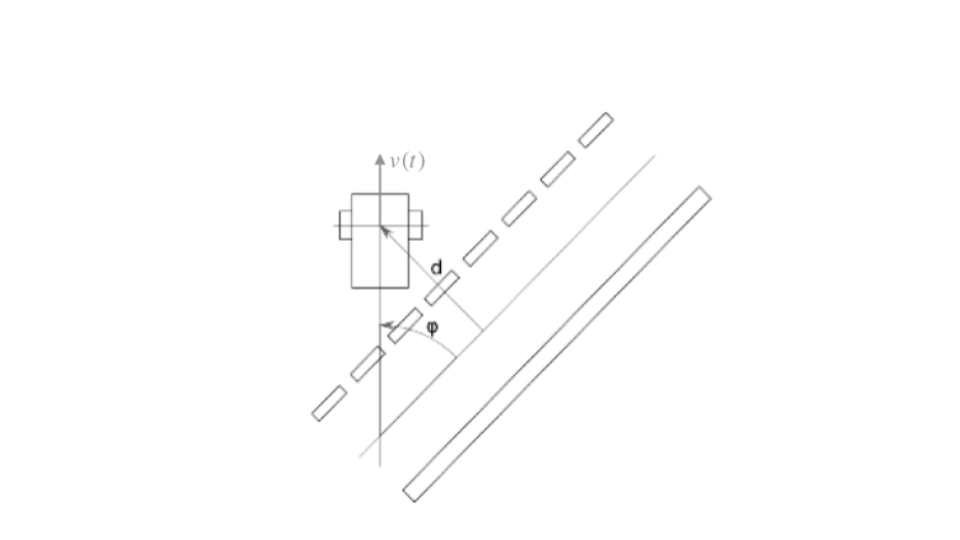

## Dynamics

The nonlinear dynamics and the output of the CS2-Bot are defined in the next cell.

In [103]:
unicycle_update = duckiebot.unicycle_update
unicycle_output = duckiebot.unicycle_output

View function definitions by right-clicking and using 'Go to Definition (F12)'. Alternatively, you can view the function definitions on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L13-L24).

Various plotting functions are defined here: [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/duckiebot.py#L27-L258)

## Parameters and Reference Track

We set a default CS2-Bot velocity and generate the nonlinear system using the `control` library.

In [104]:
# Default CS2 Bot velocity in m/s
bot_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the CS2 Bot's steering dynamics as an input/output system
bot = ct.NonlinearIOSystem(
    duckiebot.unicycle_update, duckiebot.unicycle_output, states=3, name='bot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=bot_params)

v0 = bot_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track, set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the else line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angular velocity `w_curvy`.

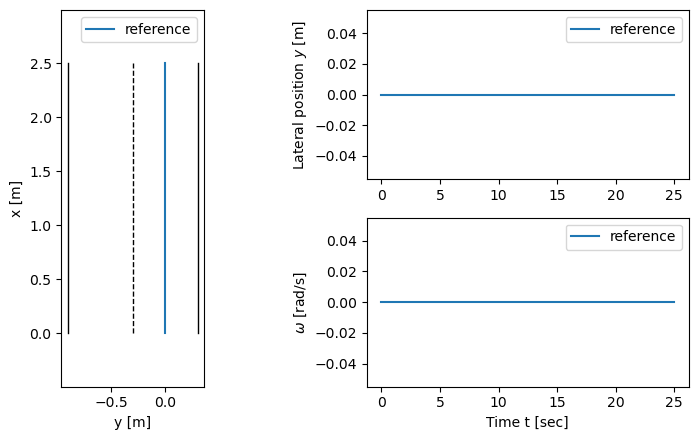

In [105]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    bot, T_curvy, u_curvy, X0_curvy, params=bot_params, return_x=True)

duckiebot.plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell, we show you how to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.

In [106]:
# Define the lateral dynamics as a subset of the full CS2 Bot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: duckiebot.unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: duckiebot.unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=bot_params)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

A = [[0.  0.1]
 [0.  0. ]]
B = [[0.]
 [1.]]
C = [[1. 0.]]
D = [[0.]]


## Adding Noise

A certain type of noise will be affecting the system. Choose the noise type you would like to test in `index_noise`, where you change the integer number to the noise index you want to test. `index_noise = 0` corresponds to constant noise (i.e., a constant shift of the states), `index_noise = 1` is random uniform noise, `index_noise = 2` is white noise, and `index_noise = 3` is no noise.

In [107]:
noise_type = ['const', 'uniform', 'white_noise', 'no_noise']
index_noise = 1
noise = noise_type[index_noise]
if noise == 'const':
    n = np.ones(r.shape)*0.5
elif noise=='uniform':
    n = np.random.uniform(low=-0.1, high=0.1, size=r.shape)
elif noise=='white_noise':
    Rw_lat = np.diag([0.001])
    n = ct.white_noise(t, Rw_lat)
else:
    n = np.zeros(r.shape)
U = np.concatenate((r, n))

## Implementing Q-Parametrization

Recall the structure of the Dynamic Output Feedback Compensator (DOFB) from Lecture 05. The following block diagram shows how Q-parametrization is introduced. The signal $v$ is the output, and the signal $h$ is the input to $Q$. In Lecture 05, we observed that the reference $r$ does not affect the innovation $ \eta = y - \hat{y} $. This implies that $v$ also has no influence on $h$ and thus the total system is stable if the parameter $Q$ is stable, assuming that the controller and the observer are stable on their own already.

In the following tasks, we will introduce the Q-parametrization to the DOFB from Lecture 05.

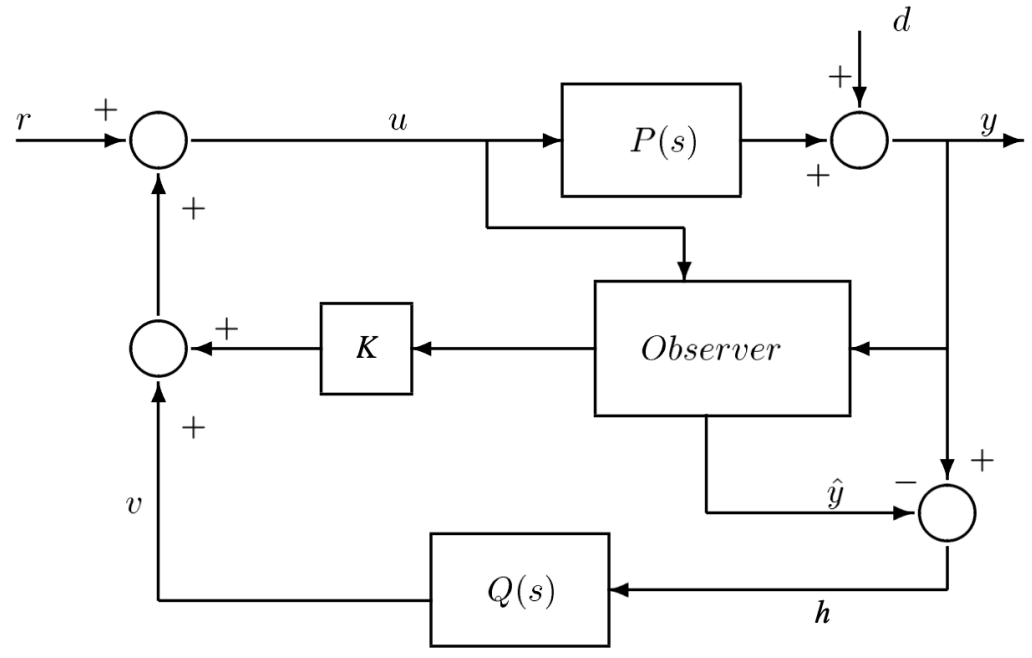

## Exercise 1.1 
Before we can introduce a $Q$-block, we need to find the transfer function of the plant $P$. For this, you can use the already computed system matrices $A$, $B$, $C$, and $D$.
Also, we need to set the state-feedback gain $K$ as well as the observer gain $L$.
You can use `ct.acker()` to place the poles.

In [108]:
# Setting the poles of the controller and observer
poles_controller = [-0.1, -0.1] # Try to change it
poles_observer = [-1, -1] # Try to change it


def compute_K_L(A, B, C, D, poles_controller, poles_observer):

    # Define the transfer function of the Plant P
    P = ct.ss2tf(A, B, C, D)

    # Compute the controller and observer gains
    K = np.array(ct.acker(A, B, poles_controller))
    L = np.array(ct.acker(A.T, C.T, poles_observer).T)

    return P, K, L

In [109]:
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)
print("poles_controller =", poles_controller)
print("poles_observer =", poles_observer)

P, K, L = Qparam.sol_compute_K_L(A, B, C, D, poles_controller, poles_observer)

A = [[0.  0.1]
 [0.  0. ]]
B = [[0.]
 [1.]]
C = [[1. 0.]]
D = [[0.]]
poles_controller = [-0.1, -0.1]
poles_observer = [-1, -1]


## Exercise 1.2
Next, we will need to define the $Q$-block. As seen in the lecture, $Q$ needs to be stable, proper, and rational.
Define the transfer function `Q` and the state-space representation `sys_q`. Print the poles to double-check the stability of $Q$.

Start with the transfer function
$$ Q = \frac{s}{s+1}.$$
After you have solved all parts of the exercise, you can come back and change the transfer function to see the effect on the stabilizing controller.

In [110]:
def compute_Q_tf_ss_poles():

    # Define the transfer function for the parameter Q
    Q = ct.TransferFunction([1, 0], [1, 1], name="Q")

    # Compute the state-space representation of Q
    sys_q = ct.tf2ss(Q)

    # Compute the poles of Q and print the result
    qpoles = ct.poles(Q)
    
    return Q, sys_q, qpoles

In [111]:
Q, sys_q, qpoles = compute_Q_tf_ss_poles()

## Exercise 1.3
Now that we have all the components of the system, we can compute the state-space representation of the full closed-loop system.

We receive the total state vector of the system by stacking the states of the Plant $P$, the states of the $Q$-Block and the innovation $\eta$:
$$ x_{cl} = \left [ \begin{array}{c} x \\ x_{Q} \\ \eta \end{array} \right]. $$

Recall that we can choose the $A$-matrices of the state-feedback subsystem and the observer subsystem with pole placement independently. This also applies to the $Q$-Block. Thus, you can compute the matrices for these subsystems individually before stacking them.

Compute the $A$-submatrices of the state-feedback and observer system, $ABK$ and $ALC$ respectively.

In [112]:
def compute_ABK_ALC(A, B, C, K, L):

    # Find the A-matrix of the state-feedback subsystem
    ABK = A - B @ K
    

    # Find the A matrix of the observer subsystem
    ALC = A - L @ C

    return ABK, ALC

In [113]:
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)
print("K =", K)
print("L =", L)
ABK, ALC = Qparam.sol_compute_ABK_ALC(A, B, C, K, L)

A = [[0.  0.1]
 [0.  0. ]]
B = [[0.]
 [1.]]
C = [[1. 0.]]
D = [[0.]]
K = [[0.1 0.2]]
L = [[ 2.]
 [10.]]


## Exercise 1.4
Calculate the total closed-loop system matrices $A_{cl}$, $B_{cl}$, $C_{cl}$, $D_{cl}$. You can do this by concatenating the different terms that appear in the total closed loop system.

Hint: You will also need the terms $BC_Q$, $BK$ and $B_QC$.

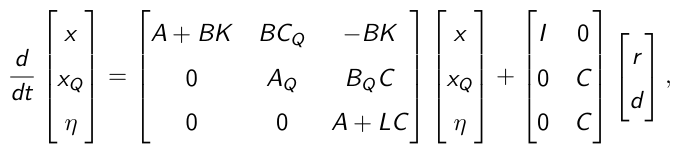

In [114]:
def compute_total_closed_loop(A, B, C, K, ABK, ALC, sys_q):

    # Define the three additional matrices we need
    BCQ = B @ sys_q.C
    BK = B @ K
    BQC = sys_q.B @ C

    # ----------------------------------------------------------------------------------------------

    # Find the A matrix of the full closed loop system
    #Concatenate the evaluated submatrices to find the first row of the total A matrix
    Acl_1 = np.concatenate((ABK, BCQ, -BK), axis=1)

    # Define the shape of the zeros-matrix at position (2,1)
    zeros_21 = np.zeros((sys_q.A.shape[0], ABK.shape[1]))

    #Concatenate the evaluated submatrices to find the second row of the total A matrix
    Acl_2 = np.concatenate((zeros_21, sys_q.A, BQC), axis=1)

    # Define the shape of the zeros-matrix at position (3, 1)
    zeros_31 = np.zeros((ABK.shape[0], ABK.shape[1]))

    # Define the shape of the zeros-matrix at position (3, 2)
    zeros_32 = np.zeros((A.shape[0], sys_q.A.shape[1]))

    #Concatenate the evaluated submatrices to find the third row of the total A matrix
    Acl_3 = np.concatenate((zeros_31, zeros_32, ALC), axis=1)

    # Concatenate the three evaluated rows to find the total A matrix
    Acl = np.concatenate((Acl_1, Acl_2, Acl_3), axis=0)

    # ----------------------------------------------------------------------------------------------

    # Find the B matrix of the full closed loop system
    # Find the components of the first row of the total B matrix
    B_11 = B
    B_12 = np.zeros((ABK.shape[0], 1))

    # Find the first row of the total B matrix
    B_1 = np.concatenate((B_11, B_12), axis=1)

    # Find the components of the first row of the total B matrix
    B_21 = np.zeros((ABK.shape[0] + sys_q.A.shape[0], 1))
    B_22 = np.ones((ABK.shape[0] + sys_q.A.shape[0], 1))

    # Find the second row of the total B matrix
    B_2 = np.concatenate((B_21, B_22), axis=1)

    # Concatenate the three evaluated rows to find the total B matrix
    Bcl = np.concatenate((B_1, B_2), axis=0)

    # ----------------------------------------------------------------------------------------------

    # Find the C matrix of the full closed loop system
    C_1 = np.zeros((1, Acl.shape[0]))
    C_1[0][0] = 1
    C_2 = np.concatenate((np.zeros((C.shape)), sys_q.C, np.zeros((C.shape))), axis=1)

    # Concatenate the two evaluated rows to find the total C matrix
    Ccl = np.concatenate((C_1, C_2), axis=0)

    # ----------------------------------------------------------------------------------------------

    # Find the D matrix of the full closed loop system
    Dcl = np.zeros((2, 2))

    # ----------------------------------------------------------------------------------------------s

    # Define the full closed loop system
    syscl = ct.ss(Acl, Bcl, Ccl, Dcl)

    return syscl, Acl, Bcl, Ccl, Dcl

In [115]:
# Calculate syscl
print("A =", A)
print("B =", B)
print("C =", C)
print("K =", K)
print("ABK =", ABK)
print("ALC =", ALC)
print("sys_q =", sys_q)
syscl, Acl, Bcl, Ccl, Dcl = Qparam.sol_compute_total_closed_loop(A, B, C, K, ABK, ALC, sys_q)


A = [[0.  0.1]
 [0.  0. ]]
B = [[0.]
 [1.]]
C = [[1. 0.]]
K = [[0.1 0.2]]
ABK = [[ 0.   0.1]
 [-0.1 -0.2]]
ALC = [[ -2.    0.1]
 [-10.    0. ]]
sys_q = A = [[-1.]]

B = [[1.]]

C = [[-1.]]

D = [[1.]]



The next code snippet simulates the response of the total system.

In [116]:
x_0 = np.zeros((Acl.shape[0],))
x_0[0] = 0.2 #define initial position

t, yout, xf = ct.forced_response(syscl, T_curvy, U, X0 = x_0, return_x=True)
yf = yout[0]
v = yout[1]
omegaf = - K @ xf[:2] + y_ref + v
omegaf = omegaf[0]

Finally, we can visualize the performance of the system. 

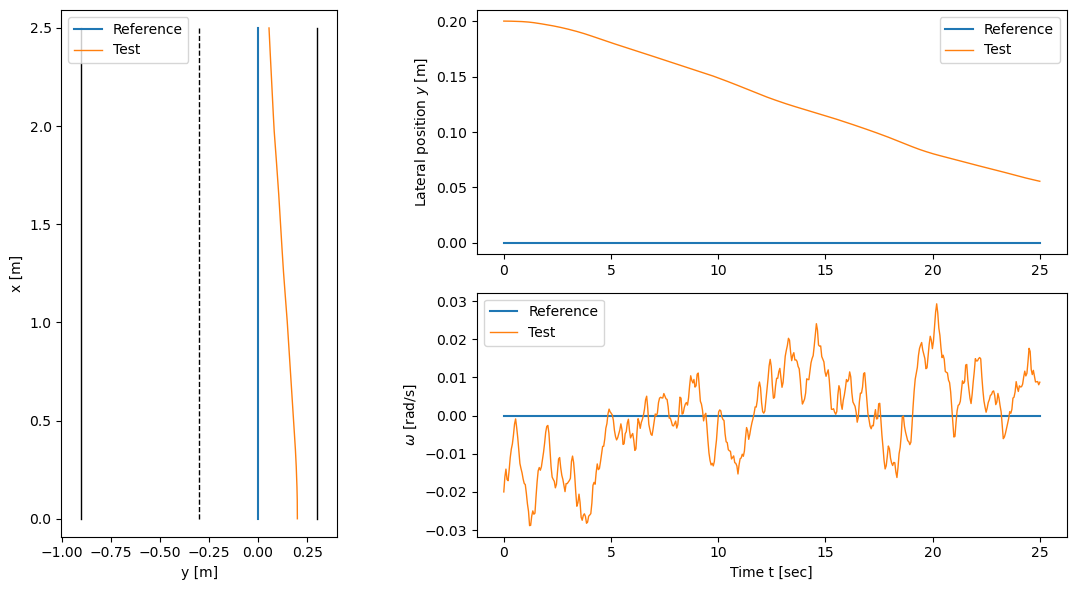

In [117]:
x_ref = x_curvy[0]
theta_ref = x_curvy[2]
omega_ref = w_curvy
y = np.array([yf])
omega = np.array([omegaf])

duckiebot.plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega, ['Test'])

Feel free to go back to the exercises and try different $Q$ transfer-functions, poles and iniatial conditions. Try and observe the effects these changes have on the system by analyzing the plot.

# Exercise 2: Modern Control Synthesis

In this task, you will learn how you can use the `control` library to set up your plants for synthesizing a controller. To express performance and stability constraints, you will create frequency weights and compute the augmented generalized plant that can be further used with various methods to synthesize a controller.

## Plant Definition

The plant used in this task models the linearized behavior of a simple inverted pendulum and is given as
$$P(s) = \frac{1}{s^2+0.1s-9.81}.$$

Note that this plant is unstable, and we will need to use a controller.

Initially, we define our controller $C(s)$ to do nothing, i.e., 
$$C(s) = 1.$$

In [118]:
P_s = ct.TransferFunction([1], [1, 0.1, -9.81], input='u', output='y', name='P(s)')
C_s = ct.TransferFunction([1], [1], input='e', output='u', name='C(s)')

print("Plant transfer function:")
display(P_s)
print("\nController transfer function:")
display(C_s)

Plant transfer function:


TransferFunction(array([1]), array([ 1.  ,  0.1 , -9.81]))


Controller transfer function:


TransferFunction(array([1]), array([1]))

We can easily check stability with `ct.poles` and see that the plant is unstable, having a pole with a positive real part.

In [119]:
ct.poles(P_s)

array([-3.18249102+0.j,  3.08249102+0.j])

## Exercise 2.1: Frequency Weights

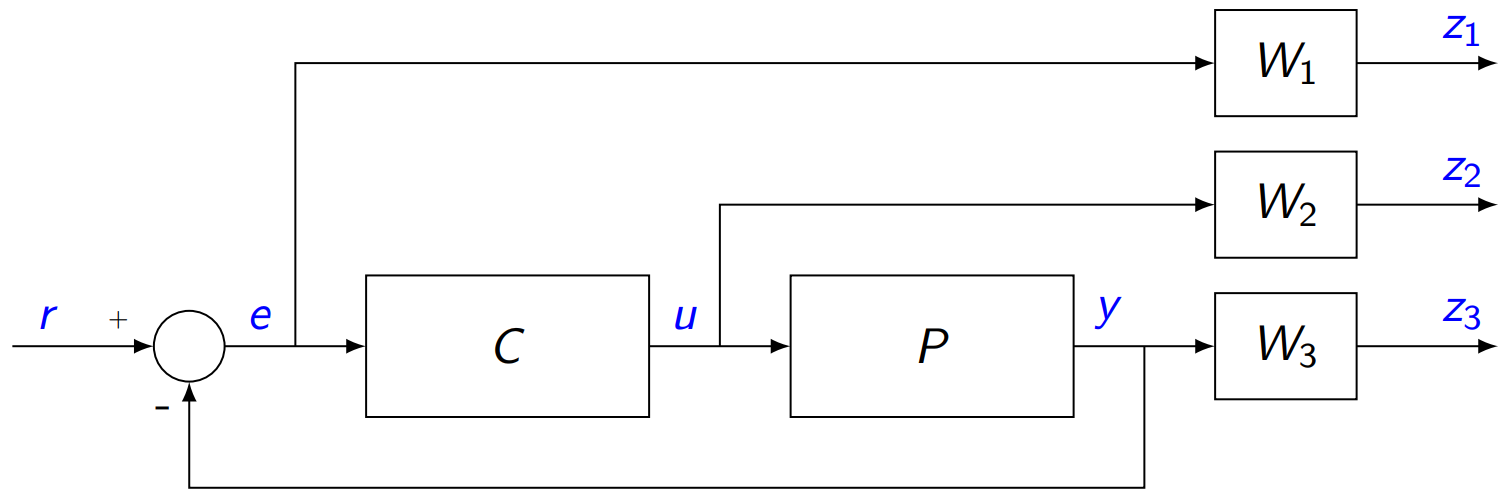


We want to create the two weights $W_1(s)$ and $W_3(s)$ to ensure reference tracking and noise attenuation.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

Therefore, we want $W_1(s)$ to have very large magnitudes at low frequencies, and $W_3(s)$ to have large magnitudes at high frequencies.

Your first task is to implement functions that create our frequency weights with the definition from Lecture 9:
$$ W_1(s) = \frac{M}{Ms/\omega_1 + 1} \quad \text{and} \quad W_3(s) = \frac{Ms}{s + M\omega_3}.

In [120]:
def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([M], [M/w1, 1], name='W_1')


def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([M, 0], [1, M*w3], name='W_3')

## Exercise 2.2: Create weight regions

Now define the two weights such that:

- $W_1(s)$ has a magnitude of 100 at low frequencies, rolls off to zero at high frequencies, and has a magnitude of 1 at a frequency of $\omega_1 = 0.1 \text{rad/s}$,
- $W_3(s)$ approaches a magnitude of 100 at high frequencies, has a magnitude of 1 at a frequency of  $\omega_3 = 10\text{rad/s}$, and has a zero DC gain.

In [121]:
W_1 = Qparam.sol_makeweight_1(100, 0.1)
W_3 = Qparam.sol_makeweight_3(100, 10)

## Visualization of Frequency weights

Now, let us look at the singular value plots of these frequency weights and compare them to the open-loop transfer function $L(s)$. Since we want 
$\sigma_{min}[L(s)] >> |W_1(s)|$
and
$\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|},$
we will invert $W_3(s)$


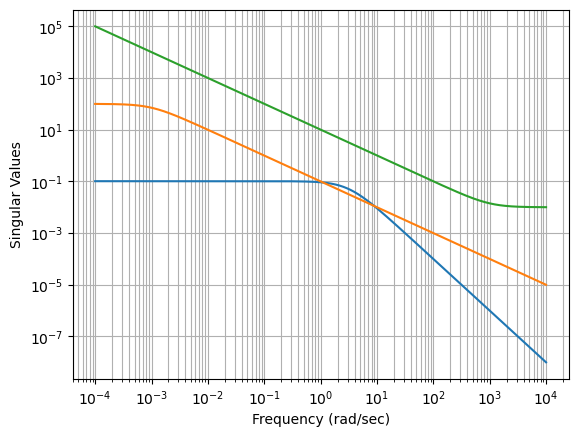

In [122]:
L_s = P_s * C_s
L_s.name = 'L(s)'

W_3_inverted = 1 / W_3
W_3_inverted.name = '1/W_3'

_ = ct.singular_values_plot([L_s, W_1, W_3_inverted])

## Assembly of the generalized plant

We want the open-loop transfer function $L(s)$ to lie between the upper and lower bounds given by $W_1(s)$ and $W_3(s)$ respectively. Note that we are dealing with a SISO system and therefore get only one singular value, implying $\sigma_{min}[L(s)] = \sigma_{max}[L(s)]$.

This loop shaping problem boils down to finding a controller $C(s)$ that places $L(s)$ between our bounds $W_1(s)$ and $W_3(s)$. We want to find the generalized plant
$$ G(s) = \begin{bmatrix} G_{zw}(s) & G_{zu}(s) \\ G_{yw}(s) & G_{yu}(s) \end{bmatrix},$$

which we can then use in an optimization problem to synthesize our controller $C(s)$.

One could derive each transfer function by hand and would find that
$$ G(s) = \begin{bmatrix} W_1(s) & -W_1(s)P(s) \\ 0 & W_3(s)P(s) \end{bmatrix},$$

or we can use the function `ct.augw(g, w1, w2, w3)` from the `control` library. \
**Caution:** due to a different nomenclature, `g` corresponds to the plant $P(s)$ and **NOT** the generalized plant $G(s)$!

In [123]:
G_s = ct.augw(P_s, w1=W_1, w2=None, w3=W_3)

display(G_s)

StateSpace(array([[-1.00e-03,  0.00e+00,  0.00e+00,  1.00e-01],
       [ 0.00e+00, -1.00e+03,  0.00e+00, -1.00e+01],
       [ 0.00e+00,  0.00e+00, -1.00e-01,  9.81e-01],
       [ 0.00e+00,  0.00e+00,  1.00e+01,  0.00e+00]]), array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  0.]]), array([[ 1.e-01,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e+03,  0.e+00, -1.e+01],
       [ 0.e+00,  0.e+00,  0.e+00,  1.e-01]]), array([[0., 0.],
       [0., 0.],
       [1., 0.]]))

Now we can use, for example, $H_2$ optimal control to synthesize our controller.

# $H_{\infty}$ Control

The function we used before:

In [124]:
def systemInfnorm(system: ct.TransferFunction) -> float:
    """
    Returns an approximation of the infinity norm of the system

    Parameters:
    - ``system`` (ct.TransferFunction): The system to compute the infinity norm of

    Returns:
    - float: The infinity norm of the system
    """
    # Create a range of frequencies to analyze over
    omega = np.linspace(-4, 4, 1000)
    H = system(omega * 1j)

    # Consider the MIMO case
    if system.ninputs > 1 or system.noutputs > 1:
        # Calculate singular values
        singular_values = [np.linalg.svd(H[..., i])[1] for i in range(len(omega))]
    # Consider the SISO case
    else:
        singular_values = [np.absolute(H[..., i]) for i in range(len(omega))]

    # Return the highest singular value
    return np.vstack(singular_values).max()

------

## Exercise 1:

As a recap from the last two weeks we will first calculate the $H_{\infty}$ norm via the state-space representation. The solution via the transfer function as introduced last week is given to check your own implementation.

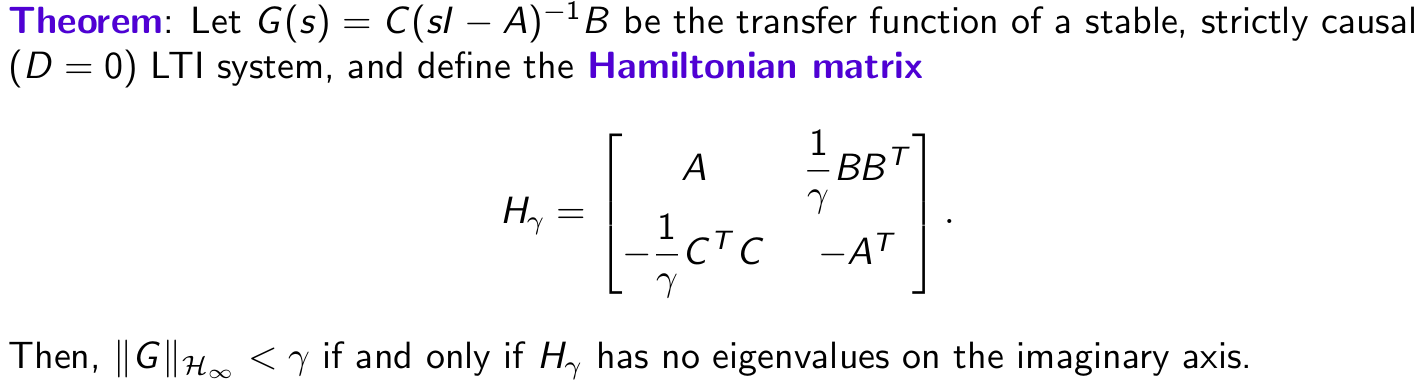

In [125]:
def H_inf_norm_state_space(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray) -> float:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """

    gamma, step, precision = 1, 1, 1
    
    while precision > 1e-7:
        # Calculate the Hamiltonian matrix
        H = np.block([[A, 1/gamma*B@B.T], [-1/gamma*C.T@C, -A.T]])

        # Check if the eigenvalues are on the imaginary axis, then update gamma
        if any(np.isclose(np.linalg.eigvals(H).real, 0)):
            prev_gamma = gamma
            gamma = gamma + step
        else:
            prev_gamma = gamma
            gamma = gamma - step
        
        precision = abs(gamma - prev_gamma)
        step /= 2
        if gamma == 0:
            gamma = 1e-7
    
    return gamma

Below, you can verify that the _state-space_ and _transfer function_ implementations of the $H_{\infty}$ norm are equivalent.

In [126]:
# Define the state space matrices. Feel free to change these to test the function. It also works for MIMO systems.
A = np.array([[0, 1], [-2, -1]])
B = np.array([[0], [1]])
C = np.array([[2, 1]])
D = np.array([[0]])

# Calculate the infinity norms using the method introduced last week
tf = ct.ss2tf(A, B, C, D)
tf_norm = systemInfnorm(tf)

# Calculate the infinity norm using the state space method
ss_norm = H_inf_norm_state_space(A, B, C, D)

# Print the results
print(f"Transfer function infinity norm: {tf_norm}")
print(f"State space infinity norm: {ss_norm}")
if np.isclose(tf_norm, ss_norm, rtol=1e-2):
    print("The infinity norms match!")
else:
    print("The infinity norms do not match!")

Transfer function infinity norm: 1.7853933874980668
State space infinity norm: 1.785405457019806
The infinity norms match!


------

## Exercise 2a:
You are working as a controls engineer at Autobau AG. It is your job to design a laneholding assistant. Because the lanes are denoted by striped lines (akin to this -----), the input data is noisy. As your first assignment you are tasked with coming up with an **optimal observer gain $L$** for your system, which looks as following.

$\dot{x}(t)=Ax(t)+B_ww(t)+B_uu(t) $

$z(t)=C_zx(t)+D_{zw}w(t)+D_{zu}(t) $

$y(t)=C_yx(t)+D_{yw}w(t)+D_{yu}u(t) $

Furthermore you can assume all initial conditions to be zero and also that $B_u = I$. You find the actual matrices below, but feel free to change them and test your own matrices.

In [127]:
A=np.array([[-10, 12, -1], [-1, 1.25, -2], [1, 0, -5]])

B_w=np.array([[0, 1, -4], [-1, 0, 2], [0, -1, 1]])
B_u=np.eye(3)

C_z=np.array([[1, 0, -1], [1, 0, 8], [0, 6, 1]])
C_y=np.eye(3)

D_zw=np.zeros((3,3))
D_zu=np.array([[-1, 0, -1], [2, 1, -3], [1, 10, 3]])
D_yw=np.array([[1, 0, 3], [6, 1, -0.5], [-1, 0, 1]])
D_yu=np.zeros((3,3))

You recall from your Control Systems II lecture that the optimal observer gain L is defined as:

$L = -(YC_y + B_w D_{yw}')R_{ww}^{-1}$

... where $Y_L$ is determined using a modified continous _algebraic riccati equation_:

$(A - B_wD_{yw}'R_{ww}^{-1}C_y)'Y + Y(A - B_wD_{yw}'R_{ww}^{-1}C_y) - YC_yR_{ww}^{-1}C_y'Y + B_w(I - D_{yw}'R_{ww}^{-1}D_{yw})B_w'=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 10-13_


It is **highly** recommended to use the scipy.linalg function [``la.solve_continous_are``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html)

In [128]:
def solve_riccati_equation(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, R_ww: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the solution to the continuous algebraic Riccati equation

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B_w`` (np.ndarray): The disturbance input matrix of the system
    - ``C_y`` (np.ndarray): The output matrix of the system
    - ``R_ww`` (np.ndarray): The disturbance covariance matrix
    - ``D_yw`` (np.ndarray): The feedthrough matrix from the disturbance to the output
    - ``Q`` (np.ndarray): The state cost matrix

    Returns:
    - np.ndarray: The solution to the continuous algebraic Riccati equation
    """
    a = (A - B_w@D_yw.T@np.linalg.inv(R_ww)@C_y).T
    b = C_y
    q = B_w@(np.eye(A.shape[0])-D_yw.T@np.linalg.inv(R_ww)@D_yw)@B_w.T
    r = np.linalg.inv(R_ww) 
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y
    

In [129]:
def optimal_LQE(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    R_ww = D_yw @ D_yw.T
    Y = solve_riccati_equation(A, B_w, C_y, R_ww, D_yw)
    L = -(Y@C_y+B_w@D_yw.T)@np.linalg.inv(R_ww)
    
    return L

Finally, print the optimal observer gain using your function or the solution function:

In [130]:
L_optimal = optimal_LQE(A, B_w, C_y, D_yw)
# L_optimal = H_inf.sol_optimal_LQE(A, B_w, C_y, D_yw)
print("The optimal state feedback gain is:")
print(L_optimal)

The optimal state feedback gain is:
[[ 2.375 -1.    -3.625]
 [-0.25   0.    -1.25 ]
 [-1.625  1.     4.375]]


## Exercise 2b: 
Similarly, the optimal controller gain can be solved using the LQR formulation presented in the slides:

$F = -(D_{zu}'D_{zu})^{-1}B_u'X_F$

... where $X_F$ is found using an _algebraic riccati equation_:

$A'X_F + X_FA+ X_FB_u(D_{zu}'D_{zu})^{-1}B_u'X_F + C_z'C_z=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 5-6_

It is **highly** recommended to use the scipy.linalg function [``la.solve_continous_are``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html)

In [131]:
def optimal_LQR(A: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, D_zu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    a = A
    b = B_u
    q = C_z.T@C_z
    r = D_zu.T@D_zu
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X_F = la.solve_continuous_are(a, b, q, r)
    F = -np.linalg.inv(r)@B_u.T@X_F
    
    return F

## Exercise 2c: 
Great, you managed to impress your project manager by coming up with an optimal observer for the LQG problem and controller for the LQR problem. 

Using the controller and observer gains $F$ and $L$ calculated earlier, he wants you to find an $H_2$-optimal controller as denoted by $K$.

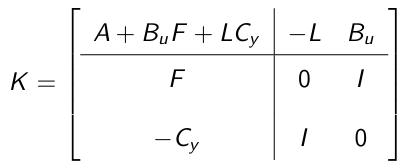

The function [``np.block``](https://numpy.org/doc/stable/reference/generated/numpy.block.html) may be of use in this exercise.

In [133]:
def optimal_controller(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    # Find the optimal observer gain
    L = optimal_LQE(A, B_w, C_y, D_yw)
    
    # Find the optimal controller gain
    F = optimal_LQR(A, B_u, C_z, D_zu)
    
    A_K = A+B_u@F+L@C_y
    B_K = np.block([[-L, B_u]])
    C_K = np.block([[F], [-C_y]])
    D_K = np.block([
        [np.zeros((F.shape[1], L.shape[0])), np.ones((F.shape[1], B_u.shape[1]))], 
        [np.ones((C_y.shape[0], L.shape[0])), np.zeros((C_y.shape[0], B_u.shape[1]))]])
    
    K = np.block([[A_K, B_K], [C_K, D_K]])
    
    return K, A_K, B_K, C_K, D_K

Use the implementation to print the controller.

------

## Exercise 3:

Now we will use the same system as before to find a suboptimal $H_{\infty}$ controller. For simplicity you can also assume **$\gamma = 0.5$**.

Solving for $X_{\infty}$ and $Y_{\infty}$ using two _continuous algebraic riccati equations_:

$X_{\infty}A + A^TX_{\infty} + X_{\infty}(\frac{1}{\gamma^2}B_wB_w^T - B_uB_u^T)X_{\infty}+C_z^TC_Z=0$

$AY_{\infty} + Y_{\infty}A^T + Y_{\infty}(\frac{1}{\gamma^2}C_zC_z^T - C_yC_y^T)Y_{\infty} + B_w^TB_w = 0$

The controller matrix is defined as follows:

$F_{\infty} = -B_u^TX_{\infty}$

$L_{\infty} = -Y_{\infty}C_y^T$

$Z_{\infty} = (I - \frac{1}{\gamma^2}X_{\infty}Y_{\infty})^{-1}$

$K = \begin{bmatrix}
A + \frac{1}{\gamma^2}B_wB_w^TX_{\infty} + B_wF_{\infty} + Z_{\infty}C_y & -Z_{\infty}L_{\infty} \\
F_{\infty} & 0 
\end{bmatrix}  $

More information on [Wikipedia](https://de.wikipedia.org/wiki/H-unendlich-Regelung).

In [ ]:
gamma = 0.5

In [135]:
def find_X_inf(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = A
    b = np.eye(A.shape[1])
    q = C_z.T@C_z
    r = np.linalg.inv(1/gamma**2*B_w@B_w.T-B_u@B_u.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X = la.solve_continuous_are(a, b, q, r)
    return X
    

In [136]:
def find_Y_inf(A: np.ndarray, B_w: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = A
    b = np.eye(A.shape[1])
    q = B_w.T@B_w
    r = np.linalg.inv(1/gamma**2*C_z@C_z.T-C_y@C_y.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y

The function [``np.block``](https://numpy.org/doc/stable/reference/generated/numpy.block.html) may be of use in this exercise.

In [139]:
def assemble_suboptimal_K(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """    
    # Find the suboptimal X_inf and Y_inf
    X_inf = find_X_inf(A, B_w, B_u, C_z, gamma)
    Y_inf = find_Y_inf(A, B_w, C_z, C_y, gamma)
    
    # Find the suboptimal gains
    F_inf = -B_u.T@X_inf
    L_inf = -Y_inf@C_y.T
    
    # Define helper matrices
    Z_inf = np.linalg.inv(np.eye(A.shape[0])-1/gamma**2*X_inf@Y_inf)
    
    # Assemble the suboptimal controller
    A_K_suboptimal = A + 1/gamma**2 *B_w@B_w.T@X_inf + B_u@F_inf + Z_inf@C_y
    B_K_suboptimal = -Z_inf@L_inf
    C_K_suboptimal = F_inf
    D_K_suboptimal = np.zeros((F_inf.shape[0], L_inf.shape[1]))
    
    K = np.block([[A_K_suboptimal, B_K_suboptimal], [C_K_suboptimal, D_K_suboptimal]])
    
    return K, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal

Finally use the implementation to find the $H_{\infty}$ controller.

In [140]:
gamma = 0.5 # Initial
K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
# K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = H_inf.assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
print("Suboptimal H_2 controller: \n", K_suboptimal)

# H_inf norm of the system
H_inf_norm = H_inf_norm_state_space(A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal)
print("H_inf norm of the system: ", H_inf_norm)


Suboptimal H_2 controller: 
 [[-1.06333561e+01 -3.28826022e+01 -3.17672979e+01  4.73952609e-02
   2.67416240e-02 -8.96339471e-02]
 [-9.85692535e-01  3.02266590e+01  6.57362361e+00  1.14356466e-03
   8.99991472e-02 -2.41311416e-02]
 [ 2.08821905e+00  1.12821827e+01  7.99217641e+00  9.78784736e-03
   5.27720557e-02 -1.00205631e-01]
 [-1.35992627e-01 -9.39016572e-03 -5.23222468e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.39016572e-03 -1.54957465e+00  1.99735921e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.23222468e-01  1.99735921e-01 -3.60255935e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
H_inf norm of the system:  0.884942452771759


In [141]:
K, A_K, B_K, C_K, D_K = optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
# K, A_K, B_K, C_K, D_K = H_inf.sol_optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
print("Optimal H_2 controller: \n", K)

print("In state space form:")
print("A_K:\n", A_K)
print("B_K:\n", B_K)
print("C_K:\n", C_K)
print("D_K:\n", D_K)

h_inf_norm = H_inf_norm_state_space(A_K, B_K, C_K, D_K)
print(f"The H_inf norm of the optimal controller is: {h_inf_norm}")

Optimal H_2 controller: 
 [[-8.1993041  15.17461758 -6.53153663 -2.375       1.          3.625
   1.          0.          0.        ]
 [-1.05757618 -0.22441738 -2.62070826  0.25       -0.          1.25
   0.          1.          0.        ]
 [-1.01429344  3.66123144 -2.04259751  1.625      -1.         -4.375
   0.          0.          1.        ]
 [-0.5743041   4.17461758 -1.90653663  0.          0.          0.
   1.          1.          1.        ]
 [ 0.19242382 -1.47441738  0.62929174  0.          0.          0.
   1.          1.          1.        ]
 [-0.38929344  2.66123144 -1.41759751  0.          0.          0.
   1.          1.          1.        ]
 [-1.         -0.         -0.          1.          1.          1.
   0.          0.          0.        ]
 [-0.         -1.         -0.          1.          1.          1.
   0.          0.          0.        ]
 [-0.         -0.         -1.          1.          1.          1.
   0.          0.          0.        ]]
In state space form: